In [30]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
sim_start_date = time.Time("2037-07-16 15:01", scale="utc").tdb
sim_end_date = time.Time("2038-07-25 01:01", scale="utc").tdb
epoch=time_range(start=sim_start_date, end=sim_end_date)

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



1067388 x 1073342 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-08-19 05:02:09.183 (TDB)


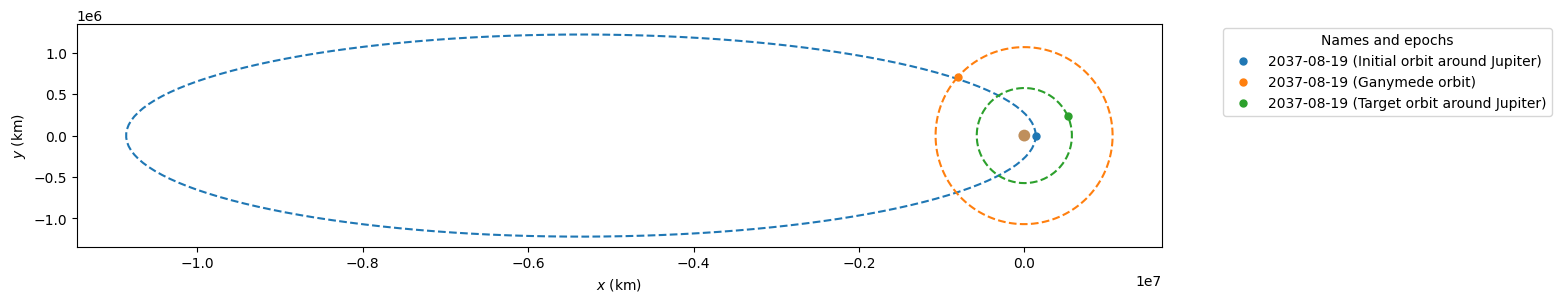

In [ ]:
start_date = time.Time("2037-08-19 05:01", scale="utc").tdb

# frame_J=frames.equatorial.JupiterICRS
# print(JupiterFixed)


plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# print(plotter.plane)

body1=Ganymede
ganymede_ephem = Ephem.from_horizons(503,epochs= epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
orb_ganymede = Orbit.from_ephem(Jupiter, ganymede_ephem, start_date)

target_orb= Orbit.circular(Jupiter, alt=504000*u.km, epoch=start_date, plane=Planes.EARTH_ECLIPTIC)

starship_orb=Orbit.from_classical(Jupiter, 5500000*u.km, 0.975*u.one, orb_ganymede.inc, orb_ganymede.raan, 0*u.deg, 0*u.deg,start_date, plane=Planes.EARTH_ECLIPTIC)
starship_orb = starship_orb.propagate_to_anomaly(0*u.deg)
starship_orb._epoch = start_date

# print(orb_ganymede.raan)
# print(orb_ganymede.inc)
plotter.plot(starship_orb, label="Initial orbit around Jupiter")
plotter.plot(orb_ganymede, label="Ganymede orbit")
plotter.plot(target_orb, label="Target orbit around Jupiter")
print(orb_ganymede)


In [32]:
# link = weakref.WeakKeyDictionary()
# link[Ganymede] = ganymede_ephem

dict={
    Ganymede: ganymede_ephem
    
}


In [77]:
#toy fitness function; make perijove match target orbit
#genes:
#1:initial epoch
#b1 - 0: first body 
#b1 - 1: arrival 1 epoch
#b1 - 2: arrival 1 deflection angle
#b1 - 3: arrival 1 perijove altitude (i*4)
#b2 - 0: second body
#b2 - 1: arrival 2 epoch
#b2 - 2: arrival 2 deflection angle
#b2 - 3: arrival 2 perijove altitude
#final arrival time



##Fitness function needs to take those 5 inputs, evaluate a lambert at perijove to ganymede
#evaluate a burn for that given slingshot garuntees final ganymede encounter
#calculate fitness as DV to reach final orbit
# plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

test_gene = [sim_start_date,Ganymede, time.Time("2037-09-12 05:01", scale="utc").tdb, 0, 2634*u.km, Ganymede, time.Time("2037-10-01 05:01", scale="utc").tdb, 0, 2634*u.km, time.Time("2037-10-20 05:01", scale="utc").tdb]

body1=Ganymede

# plotter.plot(starship_orb, label="Initial orbit around Jupiter")


def calculate_fitness(genes,encounters):
    ss_arrival = Orbit.from_ephem(Jupiter, ganymede_ephem, genes[2])
    starship_orb=Orbit.from_classical(Jupiter, 5500000*u.km, 0.975*u.one, orb_ganymede.inc, orb_ganymede.raan, 0*u.deg, 0*u.deg,start_date, plane=Planes.EARTH_ECLIPTIC)
    man_lambert_0 = Maneuver.lambert(starship_orb, ss_arrival)
    burn1_dv = np.linalg.norm(man_lambert_0[0][1])
    print(f"Burn 1 is {burn1_dv:.2f}")
    
    post_burn_orb = starship_orb.apply_maneuver(man_lambert_0,intermediate=True)[0]
    op_orb = post_burn_orb.propagate( ss_arrival.epoch - post_burn_orb.epoch)
    
    total_dv=burn1_dv
    #loop through remaining encounters
    # plotter.plot(post_burn_orb, label="Post burn orbit")
    # plotter.plot(ss_arrival, label="Ganymede orbit")
    
    for i in range(0,encounters-1):
        body = genes[4*i+1]
        ephem = dict[body]
        
        #time of encounter happening in this loop iteration
        encounter_time=genes[4*i+2]
        #next gravity assist time
        next_encounter_time=genes[4*(i+1)+2]
        
        orb_body = Orbit.from_ephem(Jupiter, ephem, encounter_time)
        print(f"Encounter {encounters-1} with {body.name} at {encounter_time.iso}")
        
        arrival_vel=op_orb.rv()[1]-orb_body.rv()[1]
        arrival_speed=np.linalg.norm(arrival_vel)

        r_p= body.R + genes[4*i+4]
        
        flip_sin=1/(1+r_p* arrival_speed**2/body.k)
        angle= math.copysign(1,genes[4*i+3])*math.asin(flip_sin*2)
        #Z seems to be out of Earth's ecliptic, which luckily means any gravity assist can be a rotation just in x & y

        rot=scipyRot.from_euler('z',angle,degrees=False)
        vel_vector_1=rot.apply(arrival_vel.value)*u.km/u.s
        v_final = vel_vector_1 + orb_ganymede.rv()[1]
        op_orb=Orbit.from_vectors(Jupiter, orb_body.rv()[0], v_final, epoch=encounter_time,plane=Planes.EARTH_ECLIPTIC)
        # plotter.plot(op_orb, label=f"Post {body} encounter orbit")
        #now burn to make next encounter
        next_orb_body = Orbit.from_ephem(Jupiter, ephem, next_encounter_time)
        man_lambert= Maneuver.lambert(op_orb, next_orb_body, M=0)
        burn_dv = np.linalg.norm(man_lambert[0][1])
        print(f"Burn {i+2} is {burn_dv:.2f}")
        total_dv+=burn_dv
        trans_orb = op_orb.apply_maneuver(man_lambert,intermediate=True)[0]
        op_orb = trans_orb.propagate(next_encounter_time-encounter_time)

    #final encounter; now just aim to reach target orbit
    final_body = genes[4*(encounters-1)+1]
    final_ephem = dict[final_body]
    final_encounter_time=genes[4*(encounters-1)+2]
    final_orb_body = Orbit.from_ephem(Jupiter, final_ephem, final_encounter_time)
    print(f"Encounter {encounters} with {final_body.name} at {final_encounter_time.iso}")
    
    arrival_vel=op_orb.rv()[1]-final_orb_body.rv()[1]
    arrival_speed=np.linalg.norm(arrival_vel)
    r_p= final_body.R + genes[4*(encounters-1)+4]
    flip_sin=1/(1+r_p* arrival_speed**2/final_body.k)
    angle= math.copysign(1,genes[4*i+3])*math.asin(flip_sin*2)
    rot=scipyRot.from_euler('z',angle,degrees=False)
    vel_vector_1=rot.apply(arrival_vel.value)*u.km/u.s
    v_final = vel_vector_1 + final_orb_body.rv()[1]
    
    #final orb, mischievously called final_orb even though final orbit is actually after the next burn
    final_orb=Orbit.from_vectors(Jupiter, final_orb_body.rv()[0], v_final, epoch=final_encounter_time,plane=Planes.EARTH_ECLIPTIC)
    #now burn to make periapsis reach target orbit

    next_orb_body = Orbit.from_ephem(Jupiter, ephem, genes[-1])
    target_orb= Orbit.circular(Jupiter, alt=504000*u.km, epoch=genes[-1], plane=Planes.EARTH_ECLIPTIC)
    man_lambert= Maneuver.lambert(final_orb, target_orb, M=0)
    sv_burn_dv= np.linalg.norm(man_lambert[0][1])
    circ_burn_dv=np.linalg.norm(man_lambert[1][1])
    total_dv+=sv_burn_dv + circ_burn_dv
    # print(circ_burn_dv)
    print(f"Burn {i+2} is {sv_burn_dv:.2f}")
    trans_orb = final_orb.apply_maneuver(man_lambert,intermediate=True)[0]
    
        
    print(starship_orb)
    print(post_burn_orb)    
    
  
    # plotter.plot(op_orb, label=f"Orbit after encounter {encounters-1}")
    # plotter.plot(final_orb, label=f"Orbit after encounter {encounters}")
    # plotter.plot(trans_orb, label=f"Final orbit after second last burn")
    # plotter.plot(target_orb, label="Target orbit around Jupiter")
    return total_dv

calculate_fitness(test_gene,2)

Burn 1 is 1832.85 m / s
Encounter 1 with Ganymede at 2037-09-12 05:02:09.183
Burn 2 is 16084.66 m / s
Encounter 2 with Ganymede at 2037-10-01 05:02:09.182
Burn 2 is 24176.82 m / s
137500 x 10862500 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-08-19 05:02:09.183 (TDB)
137246 x 4751838 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-08-19 05:02:09.183 (TDB)


<Quantity 57626.92909352 m / s>

In [ ]:
#now, try a few random genes, make them have children, give children mutations
#length should be 6+4*encounters-1

test_gene = [sim_start_date,Ganymede, time.Time("2037-09-12 05:01", scale="utc").tdb, 0, 2634*u.km, Ganymede, time.Time("2037-10-01 05:01", scale="utc").tdb, 0, 2634*u.km, time.Time("2037-10-20 05:01", scale="utc").tdb]
# body_list = [Io, Europa, Ganymede, Callisto]
body_list = [Ganymede]

sim_start_date = time.Time("2037-07-16 15:01", scale="utc").tdb
sim_end_date = time.Time("2038-01-25 01:01", scale="utc").tdb
epoch=time_range(start=sim_start_date, end=sim_end_date)

print((sim_end_date-sim_start_date).to(u.day).value)

def random_gene_generator(encounters):
    date_shift=(sim_end_date-sim_start_date).to(u.day).value
    first_date = np.random.uniform(0,date_shift)
    gene=[]
    gene.append(sim_start_date + first_date*u.day)
    leading_date = first_date
    for i in range(0,encounters):
        #each encounter could be with any of the 4 Galilean moons
        body_choice= body_list[np.random.randint(0,body_list.__len__())]
        gene.append(body_choice)
        
        #make sure that the dates are in increasing order
        encounter_date_shift=np.random.uniform(leading_date,date_shift)
        leading_date=encounter_date_shift
        gene.append(sim_start_date + encounter_date_shift*u.day)
        
        deflection_angle= np.random.uniform(-math.pi/2, math.pi/2)
        gene.append(deflection_angle)
        perijove_altitude= np.random.uniform(100,7000)*u.km+body_choice.R
        gene.append(perijove_altitude)
    #final arrival date
    final_date_shift=np.random.uniform(leading_date,date_shift)
    gene.append(sim_start_date + final_date_shift*u.day)
    return gene
random_gene_generator(2)

#what do we do?

    
def sex(gene_1,gene_2)
    

192.4166666771664


[<Time object: scale='tdb' format='iso' value=2037-09-27 10:15:35.956>,
 Ganymede (●),
 <Time object: scale='tdb' format='iso' value=2038-01-02 12:57:01.714>,
 0.7086545805852964,
 <Quantity 3552.78157577 km>,
 Ganymede (●),
 <Time object: scale='tdb' format='iso' value=2038-01-23 22:58:05.722>,
 1.024795762205919,
 <Quantity 4001.80490457 km>,
 <Time object: scale='tdb' format='iso' value=2038-01-24 22:52:54.032>]

0
1
